In [1]:
import pathlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers,Input, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model

In [2]:
import os
path = "Soja" # replace with your folder path
data_dir = pathlib.Path(path)

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

#define some parameters to the loader
batch_size = 48
img_height = 227
img_width = 227

5513


In [3]:
#Creating a list of images
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
#Creating the class list
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['Broken soybeans' 'Immature soybeans' 'Intact soybeans'
 'Skin-damaged soybeans' 'Spotted soybeans']


In [4]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  one_hot = parts[-2] == class_names
  return tf.argmax(one_hot)

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [5]:
#splitting the dataset into train, test and validation sets
train_size = int(0.7 * image_count)
test_size = int(0.15 * image_count)

train_ds = list_ds.take(train_size)
test_ds = list_ds.skip(train_size)
val_ds = test_ds.skip(test_size)
test_ds = test_ds.take(test_size)

print('Training size:', len(train_ds))
print('Validation size:', len(val_ds))
print('Test size:', len(test_ds))

Training size: 3859
Validation size: 828
Test size: 826


In [6]:
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))

In [7]:

def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=tf.data.AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

The first function is based on this image:
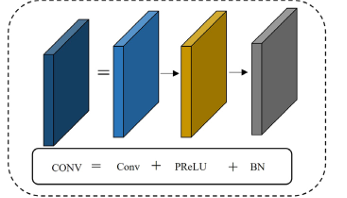

The second function is the inception module:
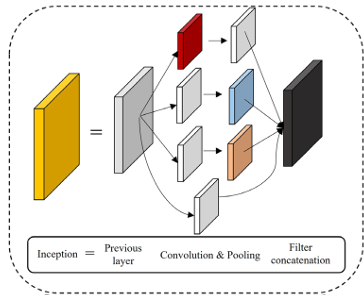

The third and fourth function is based on the image below:
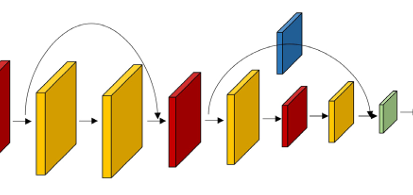

In [10]:
# The CONV block
def Conv(input_layer,filters,k_size, stride, padding):
    x = layers.Conv2D(filters = filters, kernel_size=k_size, strides=stride, padding=padding,activation=None)(input_layer)
    x = layers.PReLU()(x)
    output = layers.BatchNormalization()(x)
    return output
def inception_module(x,f1,f2_in,f2_out,f3_in,f3_out,f4_out):
    # 1x1 branch
    conv1 = layers.Conv2D(f1, (1,1), padding='same', strides = (1,1), activation='relu')(x)
    # 3x3 branch
    conv3 = layers.Conv2D(f2_in, (1,1), padding='same', activation='relu')(x)
    conv3 = layers.Conv2D(f2_out, (3,3), padding='same',activation='relu')(conv3)
    # 5x5 branch
    conv5 = layers.Conv2D(f3_in, (1,1), padding='same', activation='relu')(x)
    conv5 = layers.Conv2D(f3_out, (5,5), padding='same',activation='relu')(conv5)
    # max pooling branch
    pool = layers.MaxPooling2D((3,3),strides=(1,1),padding='same')(x)
    pool = layers.Conv2D(f4_out,(1,1),padding='same',activation='relu')(pool)
    # concatenate the branches
    output = layers.concatenate([conv1,conv3,conv5,pool], axis=-1)
    return output

def residual_block(x):
    x_inp = x
    
    x = inception_module(x,f1=64, f2_in=128, f2_out=128, f3_in=32, f3_out=64, f4_out=32)
    x = inception_module(x,f1=64, f2_in=128, f2_out=128, f3_in=32, f3_out=64, f4_out=32)
    if x.shape[-1] != x_inp.shape[-1]:
        x_inp = layers.Conv2D(x.shape[-1],(1,1),padding='same', activation='relu', kernel_initializer='he_normal')(x)
        print(x_inp.shape[-1])
    layer_out = layers.add([x,x_inp])
    layer_out = layers.Activation('relu')(layer_out)
    return layer_out

def residual_block_conv(x):
    x_inp = x
    x_inp = layers.Conv2D(288, (3,3), strides=(2,2), padding='same', activation='relu')(x)
    
    x = inception_module(x,f1=64, f2_in=128, f2_out=128, f3_in=32, f3_out=64, f4_out=32)
    x = layers.MaxPooling2D((2,2),strides=(2,2),padding='same')(x)
    x = inception_module(x,f1=64, f2_in=128, f2_out=128, f3_in=32, f3_out=64, f4_out=32)
    if x.shape[-1] != x_inp.shape[-1]:
        x_inp = layers.Conv2D(x.shape[-1],(1,1),padding='same', activation='relu', kernel_initializer='he_normal')(x)
        
    layer_out = layers.add([x,x_inp])
    layer_out = layers.Activation('relu')(layer_out)
    return layer_out

def learning_rate_schedule(epoch):
    initial_lr = 0.001  
    drop = 0.95  
    epochs_drop = 5 
    lr = initial_lr * (drop ** (epoch/ epochs_drop))
    return lr

def resize_and_rescale(x):
    x = layers.Resizing(227,227)(x)
    x = layers.Rescaling(1./255)
    return x

def data_augmentation(x):
    x = layers.RandomFlip("horizontal_and_vertical")(x)
    x = layers.RandomRotation(0.2)(x)
    return x

In [15]:
input_img = Input(shape=(227, 227, 3))  # Example input shape (224x224 RGB image)
x = data_augmentation(input_img)
x = Conv(input_layer=x, filters=8,k_size=(3,3),stride=(2,2), padding='valid')
x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)
x = Conv(input_layer=x, filters=16,k_size=(1,1),stride=(2,2), padding='valid')
x = layers.MaxPooling2D(pool_size=(2,2), strides=(1,1), padding='same')(x)
x = residual_block(x)
x = layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(x)
x = residual_block_conv(x)
x = layers.AveragePooling2D((1,1))(x)
x = layers.Flatten()(x)
x = layers.Dense(64)(x)
x = layers.Dense(len(class_names))(x)

# Create the model
model = Model(inputs=input_img, outputs=x)

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate_schedule(0)), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(learning_rate_schedule)
# Print the model summary
model.summary()

#put data augmentation

288


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 227, 227,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_4       │ (None, 227, 227,  │          0 │ input_layer_4[0]… │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_2   │ (None, 227, 227,  │          0 │ random_flip_4[0]… │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 113, 113,  │        224 │ random_rotation_… │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_4 (PReLU)   │ (None, 113, 113,  │    102,152 │ conv2d_56[0][0]   │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 113, 113,  │         32 │ p_re_lu_4[0][0]   │
│ (BatchNormalizatio… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 56, 56, 8) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 28, 28,    │        144 │ max_pooling2d_16… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ p_re_lu_5 (PReLU)   │ (None, 28, 28,    │     12,544 │ conv2d_57[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │         64 │ p_re_lu_5[0][0]   │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_59 (Conv2D)  │ (None, 28, 28,    │      2,176 │ max_pooling2d_17… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_61 (Conv2D)  │ (None, 28, 28,    │        544 │ max_pooling2d_17… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 28, 28,    │          0 │ max_pooling2d_17… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_58 (Conv2D)  │ (None, 28, 28,    │      1,088 │ max_pooling2d_17… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_60 (Conv2D)  │ (None, 28, 28,    │    147,584 │ conv2d_59[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_62 (Conv2D)  │ (None, 28, 28,    │     51,264 │ conv2d_61[0][0] 

 Total params: 2,870,429 (10.95 MB)

 Trainable params: 2,870,381 (10.95 MB)

 Non-trainable params: 48 (192.00 B)

In [16]:
epochs = 400

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[lr_scheduler]
)

Epoch 1/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 64s 681ms/step - accuracy: 0.3015 - loss: 5.7664 - val_accuracy: 0.3321 - val_loss: 1.5065 - learning_rate: 0.0010
Epoch 2/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 54s 670ms/step - accuracy: 0.5062 - loss: 1.1525 - val_accuracy: 0.5773 - val_loss: 1.0649 - learning_rate: 9.8979e-04
Epoch 3/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 676ms/step - accuracy: 0.6443 - loss: 0.8772 - val_accuracy: 0.3998 - val_loss: 1.8120 - learning_rate: 9.7969e-04
Epoch 4/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 676ms/step - accuracy: 0.7012 - loss: 0.7806 - val_accuracy: 0.3587 - val_loss: 5.2256 - learning_rate: 9.6969e-04
Epoch 5/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 680ms/step - accuracy: 0.7608 - loss: 0.6268 - val_accuracy: 0.7355 - val_loss: 0.7057 - learning_rate: 9.5980e-04
Epoch 6/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 676ms/step - accuracy: 0.7693 - loss: 0.5920 - val_accuracy: 0.6775 - val_loss: 0.8203 - learning_rate: 9.5000e-04
Epoch 7/400
81/81 ━━━━━━━━━━━━━━━━━━━━ 55s 686ms/step - 

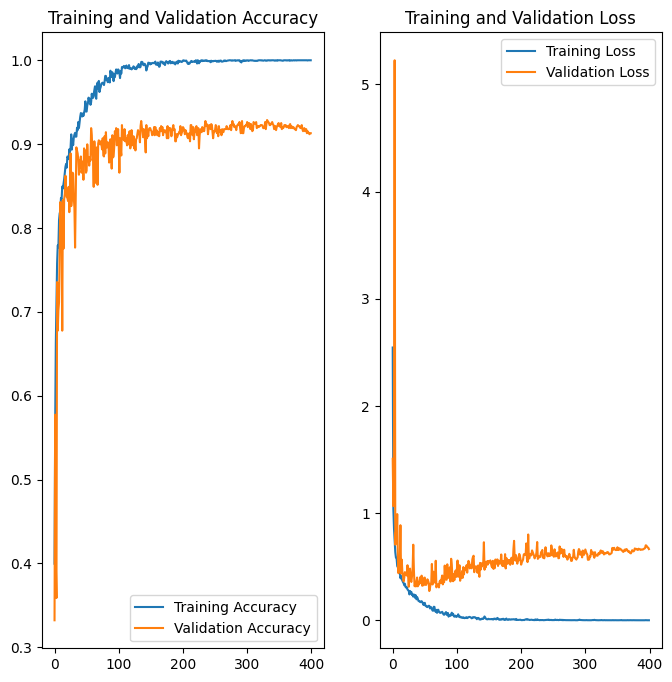

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()